# Example to perform causal discovery using CAMUV with bootstrap and imputation on data with discrete variables

This notebook explains how to perform causal discovery with multiple imputations on data with missing values when exogenous, endogenous, and sink variables are assumed, as well as when discrete ordinal variables are included in the exogenous and sink variables.  

Most algorithms implemented in lingam package can't be applied to data containing discrete variables. However, when discrete variables are included in exogenous or sink variables, it is possible to perform causal discovery by incorporating the ideas described in this notebook.  

Hereinafter, `NaN` or `nan` represents missing values.

**Note:** If your dataset does not contain missing values, please refer to the following example instead:  
[Example to perform causal discovery on data with discrete variables](https://github.com/cdt15/lingam/blob/master/examples/Example_to_perform_causal_discovery_on_data_with_discrete_variables.ipynb)


## Preparation

### Import packages

In [28]:
import os
import requests
import numpy as np
import pandas as pd
from collections import deque

from lingam import MultiGroupCAMUV, BootstrapResult
from lingam.utils import remove_effect, make_dot, make_prior_knowledge, print_dagc, print_causal_directions
from lingam.tools import BaseMultipleImputation, BaseMultiGroupCDModel
from lingam.tools import bootstrap_with_imputation

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.special import expit

import matplotlib.pyplot as plt
import graphviz as gv
from IPython.display import display, Markdown

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Using the following package versions:
- numpy: 1.26.4
- pandas: 2.3.3
- scipy: 1.10.1
- lingam: 1.11.0
- scikit-learn: 1.7.2
- matplotlib: 3.10.7
- graphviz: 0.21

### Config

In [29]:
np.random.seed(0)

# number of multiple imputations
n_repeats = 20

We summarize the results of multiple imputation across three modeling approaches.
The variable model_type is a string that specifies which approach to use when aggregating results. It supports the following options:

1. "saenet" – Elastic Net Logistic Regression implemented with the miselect package.
2. "logistic" – Standard Logistic Regression.
3. "nonlinear_logistic" – Nonlinear Logistic Regression, which may include polynomial terms or interaction effects.

In [30]:
# Variable to indicate which model type is used
# Options: "saenet", "logistic", "nonlinear_logistic"
model_type = "saenet"

### Download source code

To run this notebook, you need to download and set up the source code for [pruning_missing_data](https://github.com/cdt15/pruning_missing_data). The source code can be downloaded and imported by executing the code below, but the R environment, along with the mice and miselect packages, must be installed manually.

In [31]:
def _get_code(url, dirname="."):
    res = requests.get(url)
    if res.status_code != 200:
        raise RuntimeError("Couldn't get a source code.")
    
    with open(dirname + os.sep + url.split("/")[-1], "w", encoding="utf-8") as f:
        f.write(res.text)
        
# destinaiton of downloaded source code
dirname = "pruning_missing_data"
if not os.path.isdir(dirname):
    os.mkdir(dirname)

    # download required source code
    _get_code("https://raw.githubusercontent.com/cdt15/pruning_missing_data/refs/heads/main/pruning_missing_data/__init__.py", dirname=dirname)
    _get_code("https://raw.githubusercontent.com/cdt15/pruning_missing_data/refs/heads/main/pruning_missing_data/_estimate_adj_matrix_for_stacked_imputed_datasets.py", dirname=dirname)
    _get_code("https://raw.githubusercontent.com/cdt15/pruning_missing_data/refs/heads/main/pruning_missing_data/_impute_by_mice.py", dirname=dirname)
    _get_code("https://raw.githubusercontent.com/cdt15/pruning_missing_data/refs/heads/main/pruning_missing_data/estimate_adj_matrix_for_stacked_imputed_datasets.r", dirname=dirname)
    _get_code("https://raw.githubusercontent.com/cdt15/pruning_missing_data/refs/heads/main/pruning_missing_data/impute_by_mice.r", dirname=dirname)

from pruning_missing_data import impute_by_mice, estimate_adj_matrix_for_stacked_imputed_datasets

# check that dounwloaded source code works properly
try:
    X = np.zeros((2, 10))
    X[0] = np.random.uniform(size=10)
    X[1] = (0.5 >= np.random.uniform(0, 1, size=10)).astype(int)
    X = pd.DataFrame(X).T
    missing_pos = []
    for i, prop in enumerate([0.5, 0.5]):
        mask = np.random.uniform(0, 1, size=len(X))
        missing_pos.append(mask < prop)
    missing_pos = np.array(missing_pos).T
    X[missing_pos] = np.nan
    X_list = impute_by_mice(X, n_imputations=3, is_discrete=[False, True], seed=42)
except:
    raise RuntimeError("Check that the R and mice packages are installed and that the path to the Rscript is set correctly.")


## Test data

### Adjacency matrix

In [32]:
m = np.array([
    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
    [0.0000, 0.5215, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
    [0.0000, 0.8635, 0.2685, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6425],
    [0.5205, 0.0000, 0.0000, 0.2135, 0.4555, 0.0000, 0.0000, 0.0000, 0.0000],
    [0.0000, 0.0000, 0.0000, 0.9800, 0.0000, 0.0000, 0.0000, 0.0000, 0.7325],
    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4415, 0.6925, 0.0000, 0.0000],
    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
])

names = [f"x{i + 1}" for i in range(len(m))]
m = pd.DataFrame(m, columns=names, index=names)

m

,x1,x2,x3,x4,x5,x6,x7,x8,x9
x1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000
x2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000
x3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000
x4,0.0000,0.5215,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000
x5,0.0000,0.8635,0.2685,0.0000,0.0000,0.0000,0.0000,0.0,0.6425
x6,0.5205,0.0000,0.0000,0.2135,0.4555,0.0000,0.0000,0.0,0.0000
x7,0.0000,0.0000,0.0000,0.9800,0.0000,0.0000,0.0000,0.0,0.7325
x8,0.0000,0.0000,0.0000,0.0000,0.0000,0.4415,0.6925,0.0,0.0000
x9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000


This adjacency matrix is drawn as a following causal graph:

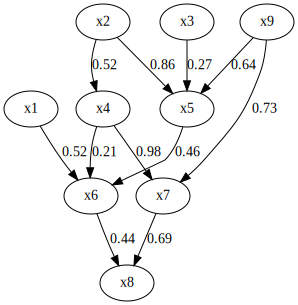

In [33]:
dot = make_dot(m, lower_limit=0, labels=m.columns.tolist())
dot.render(format="svg")
display(dot)

### Generate test data

Test data is generated based on the adjacency matrix, with x1 and x8 created as discrete variables taking values of 0 or 1. Additionally, x9 is treated as an unobserved hidden common cause.

In [34]:
# settings
n_sample = 1000
discrete_indices = [0, 7]

# initialize
X = np.zeros((len(m), n_sample))

# generate test data according to m
for i in range(len(m)):
    if i not in discrete_indices:
        X[i] = m.iloc[i] @ X + np.random.uniform(-1.732, 1.732, size=n_sample)
    else:
        X[i] = (expit(m.iloc[i] @ X) >= np.random.uniform(0, 1, size=n_sample)).astype(int)
X = pd.DataFrame(X.T, columns=names)

# convert types of continuous variables to float, types of discrete variables to int
dtypes = {}
for i, name in enumerate(names):
    dtypes[name] = int if i in discrete_indices else float
X = X.astype(dtypes)

X = X.iloc[:, :-1]

`impute_by_mice` imputes given data with missing values. The following code generates data with missing values.

In [35]:
def generate_missing_pos(X, prop_missing):
    missing_pos = []
    for i, prop in enumerate(prop_missing):
        mask = np.random.uniform(0, 1, size=len(X))
        missing_pos.append(mask < prop)
    missing_pos = np.array(missing_pos).T
    
    return missing_pos

prop_missing = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
missing_pos = generate_missing_pos(X, prop_missing)

# keep true values
true_values = X.copy()
true_values[~missing_pos] = np.nan

X[missing_pos] = np.nan

Actual proportions of missing values are as follows:

In [36]:
np.isnan(X).sum(axis=0) / len(X)

x1    0.098
x2    0.098
x3    0.099
x4    0.109
x5    0.115
x6    0.110
x7    0.107
x8    0.114
dtype: float64

Histograms of test data are as follows:

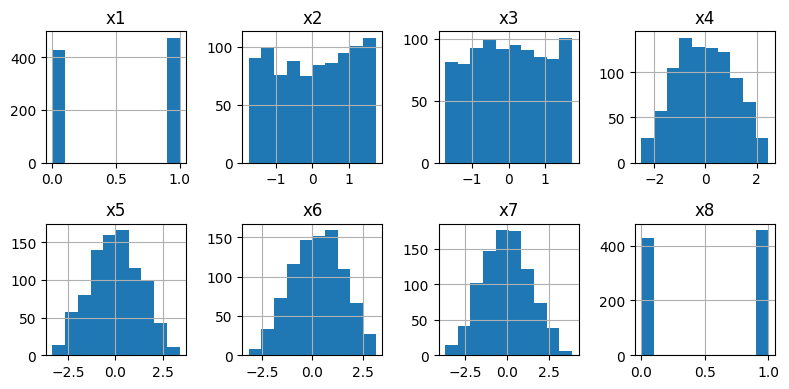

In [37]:
X.hist(layout=(2, 4), figsize=(8, 4))
plt.tight_layout()
plt.show()

Types of test data are as follows:

In [38]:
X.dtypes

x1    float64
x2    float64
x3    float64
x4    float64
x5    float64
x6    float64
x7    float64
x8    float64
dtype: object

## Analysis

This chapter demonstrates how to perform causal discovery on data that includes both discrete variables and missing values.

### Classify test data variables into three subsets  

We classify test data variables into three subsets: exogenous variables, endogenous variables, and sink variables.  
Additionally, we create a Boolean list that indicates which variables are discrete.

In [39]:
exog_var_names = ["x1", "x2", "x3"]
endog_var_names = ["x4", "x5", "x6", "x7"]
sink_var_name = "x8"

exog_indices = [X.columns.tolist().index(v) for v in exog_var_names]
endog_indices = [X.columns.tolist().index(v) for v in endog_var_names]
sink_index = X.columns.tolist().index(sink_var_name)

is_discrete = [True if i in discrete_indices else False for i in range(len(X.columns))]
is_discrete

[True, False, False, False, False, False, False, True]

The causal graph is as follows:

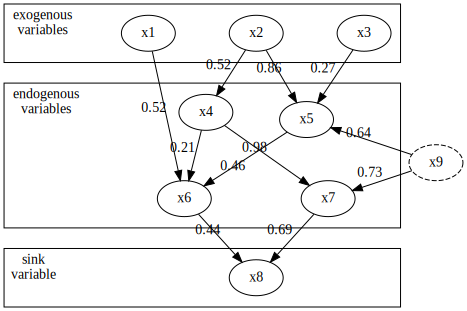

In [40]:
def display_graph(m, exog_var_names, endog_var_names, sink_var_name):
    g = gv.Digraph(engine="neato", graph_attr={"splines":"true"})

    cluster_names = ["exogenous", "endogenous", "sink"]

    node_kws = {
        "x1": {"pos": "0,0!"},
        "x2": {"pos": "1.5,0!"},
        "x3": {"pos": "3.0,0!"},
        "x4": {"pos": "0.8,-1.1!"},
        "x5": {"pos": "2.2,-1.2!"},
        "x6": {"pos": "0.5,-2.3!"},
        "x7": {"pos": "2.5,-2.3!"},
        "x8": {"pos": "1.5,-3.4!"},
        "x9": {"pos": "4.0,-1.8!", "style": "dashed"}  # latent variable
    }

    dummy_node_kws = {
        "exogenous": [
            {"pos":"-2,0.4!", "style":"invis", "fixedsize":"true", "width":"0", "height":"0"},
            {"pos":"3.5,-0.4!", "style":"invis", "fixedsize":"true", "width":"0", "height":"0"},
        ],
        "endogenous": [
            {"pos":"-2,-0.7!", "style":"invis", "fixedsize":"true", "width":"0", "height":"0"},
            {"pos":"3.5,-2.7!", "style":"invis", "fixedsize":"true", "width":"0", "height":"0"},
        ],
        "sink": [
            {"pos":"-2,-3.0!", "style":"invis", "fixedsize":"true", "width":"0", "height":"0"},
            {"pos":"3.5,-3.8!", "style":"invis", "fixedsize":"true", "width":"0", "height":"0"},
        ]
    }

    # add nodes
    for cluster_name, var_names in zip(cluster_names, [exog_var_names, endog_var_names, [sink_var_name]]):
        # make subgraph
        with g.subgraph(name=f"cluster_{cluster_name}", graph_attr={"margin":"4,4!"}) as sub:
            for var_name in var_names:
                kw = {} if var_name not in node_kws.keys() else node_kws[var_name]
                sub.node(var_name, var_name, **kw)
            s = "" if cluster_name == "sink" else "s"
            sub.attr(label=f"{cluster_name}\nvariable" + s, labeljust="l")

            # dummies
            sub.node(cluster_name + "_lu", "", **dummy_node_kws[cluster_name][0])
            sub.node(cluster_name + "_rl", "", **dummy_node_kws[cluster_name][1])

    # add edges
    for to_name, coefs in m.iterrows():
        for from_name, coef in coefs.items():
            if np.isclose(coef, 0):
                continue

            g.edge(from_name, to_name, label=f"{coef:.2f}")
            
    g.node("x9", "x9", **node_kws["x9"])
    display(g)
    g.render(format="svg")

display_graph(m, exog_var_names, endog_var_names, sink_var_name)

### Perform causal discovery

we apply multiple imputation using `impute_by_mice` to fill in the missing values in the test data $X$.

In [41]:
X_list = impute_by_mice(X, n_imputations=n_repeats, is_discrete=is_discrete, seed=0)

### Causal Discovery After Removing Exogenous Effects

1. **Remove exogenous effects**  
   For each imputed dataset in X_list, we regress out the influence of exogenous variables. This produces adjusted datasets where endogenous variables can be analyzed without confounding from exogenous variables.
2. **Infer causal ordering among endogenous variables**  
   From the adjusted datasets, we extract only the endogenous variables and apply the MultiGroupRESIT method with a RandomForestRegressor. This method is designed for causal discovery across multiple datasets and estimates a consistent causal order for the endogenous variables.

In [42]:
# remove effects of exogenous variables from X by regression
X_removed_exog_list = [remove_effect(X_, exog_indices) for X_ in X_list]

# A list of datasets of endogenous variables with the effects of exogenous variables removed
X_endog_list = [arr[:, endog_indices] for arr in X_removed_exog_list]

# Causal discovery among endogenous variables after removing the effects of exogenous variables
cd_model = MultiGroupCAMUV()
cd_model.fit(X_endog_list)

3. **Construct the overall causal order**  
   We define the global causal order by arranging variables in the following sequence:  
   exogenous variables → endogenous variables (in topological order) → sink variable.  
   No specific causal order is assumed among exogenous variables, and the sink variable is always placed at the end.

In [43]:
# Function to construct causal order (topological sort) from adjacency matrix
def adjacency_to_causal_order(adj_matrix):
    n = adj_matrix.shape[0]
    indegree = np.sum(adj_matrix == 1, axis=1)
    order = []
    queue = deque([i for i in range(n) if indegree[i] == 0])
    while queue:
        v = queue.popleft()
        order.append(v)
        for i in range(n):
            if adj_matrix[i, v] == 1:
                indegree[i] -= 1
                if indegree[i] == 0:
                    queue.append(i)
    if len(order) != n:
        print('Warning: The graph may not be a DAG (cycle detected)')
    return order

endog_causal_order = adjacency_to_causal_order(cd_model.adjacency_matrix_)
# Overall causal order
causal_order = exog_indices + [endog_indices[i] for i in endog_causal_order] + [sink_index]
causal_order

[0, 1, 2, 3, 4, 5, 6, 7]

### Sink Model Across Imputations: Linear Logistic Regression
4. **Estimate the sink variable model (linear case)**  
   Since the sink variable is discrete, we fit a logistic regression model for each imputed dataset using the raw exogenous and endogenous predictors.  
   For each imputation, we store the coefficient vector and intercept.
5. **Aggregate coefficients and update the adjacency matrix**  
   Compute the median coefficients and median intercept across all imputations.  
   Insert the median coefficients into the adjacency matrix row corresponding to the sink variable to represent its dependence on exogenous and endogenous variables.

### Sink Model Across Imputations: Nonlinear Logistic Regression
4. **Estimate the sink variable model (nonlinear case)**  
   To capture nonlinear relationships, we apply polynomial feature expansion (e.g., quadratic terms and interactions) to the predictors before fitting logistic regression.  
   For each imputation, we store the expanded-feature coefficients, intercept, and optionally generate a readable regression equation using polynomial feature names.
5. **Handle adjacency matrix update for nonlinear case**  
   Polynomial expansion creates additional interaction and squared terms, so coefficients cannot be directly mapped back to original variables.  
   As a placeholder, we set all connections from exogenous and endogenous variables to the sink as 1.0.

### Sink Model Across Imputations using saenet
4. **Encode prior knowledge and constraints**  
   Define prior knowledge including:
   * Exogenous variables
   * Sink variable
   * Forbidden paths (e.g., no direct paths from exogenous variables to the sink variable)
   This guides adjacency matrix estimation.
5. **Estimate adjacency matrix across imputations**  
   Use estimate_adj_matrix_for_stacked_imputed_datasets to aggregate results from multiple imputations into a single adjacency matrix.  
   Apply weights based on missingness and use ad_weight_type="min" for conservative aggregation.  
   Finally, apply saenet pruning to produce the final adjacency matrix.
6. **Handle exogenous variable relationships**  
   Since we assume potential unobserved common causes among exogenous variables, their mutual relationships are marked as NaN in the adjacency matrix rather than assigning explicit edges.

In [44]:
if model_type == "logistic":
    coefs, intercepts = [], []
    # Indices for predictors (exclude sink in causal discovery)
    exog_and_endog_indices = exog_indices + endog_indices
    # Linear logistic on raw predictors (exog + endog)
    for X_ in X_list:
        sink_model = LogisticRegression(penalty=None, max_iter=1000)
        sink_model.fit(X_[:, exog_and_endog_indices], X_[:, sink_index])
        coefs.append(sink_model.coef_[0])          # shape: (n_features_subset,)
        intercepts.append(sink_model.intercept_[0]) # scalar

    coefs = np.array(coefs)              # (n_imputations, n_features_subset)
    intercepts = np.array(intercepts)    # (n_imputations,)
    median_coef = np.median(coefs, axis=0)
    median_intercept = float(np.median(intercepts))

    adj = np.zeros((X_list[0].shape[1], X_list[0].shape[1]), dtype=float)
    # Create edges following the inferred order (DAG: earlier -> later)
    for i, from_ in enumerate(causal_order):
        for to in causal_order[i+1:]:
            adj[to, from_] = 1.0
    # Embed endogenous adjacency into the global matrix
    adj[np.ix_(endog_indices, endog_indices)] = cd_model.adjacency_matrix_
    # Map median linear coefficients directly into adjacency sink row
    adj[sink_index, exog_and_endog_indices] = median_coef

elif model_type == "nonlinear_logistic":
    coefs, intercepts, equations = [], [], []
    # Indices for predictors (exclude sink in causal discovery)
    exog_and_endog_indices = exog_indices + endog_indices
    poly_degree = 2
    # Nonlinear logistic with polynomial features (quadratic + interactions)
    for X_ in X_list:
        sink_model = make_pipeline(
            PolynomialFeatures(degree=poly_degree, include_bias=False),
            LogisticRegression(max_iter=1000)
        )
        sink_model.fit(X_[:, exog_and_endog_indices], X_[:, sink_index])

        coef_vec = sink_model.named_steps['logisticregression'].coef_[0]
        intercept = sink_model.named_steps['logisticregression'].intercept_[0]
        coefs.append(coef_vec)
        intercepts.append(intercept)

        poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
        poly_features.fit(X_[:, exog_and_endog_indices])
        feature_names = poly_features.get_feature_names_out(input_features=X.columns[exog_and_endog_indices])
        equation = f"{intercept:.3f} + " + " + ".join(f"{c:.3f}*{n}" for c, n in zip(coef_vec, feature_names))
        equations.append(equation)

    adj = np.zeros((X_list[0].shape[1], X_list[0].shape[1]), dtype=float)
    
    # Create edges following the inferred order (DAG: earlier -> later)
    for i, from_ in enumerate(causal_order):
        for to in causal_order[i+1:]:
            adj[to, from_] = 1.0
    # Embed endogenous adjacency into the global matrix
    adj[np.ix_(endog_indices, endog_indices)] = cd_model.adjacency_matrix_
    # Here we set all connections from exogenous and endogenous variables to the sink as 1.0
    # because polynomial coefficients cannot be directly mapped back to original variables.
    adj[sink_index, exog_and_endog_indices] = 1.0

elif model_type == "saenet":
    # There is no causal path from exogenous variables to sink variables
    no_paths = [(exog_index_, sink_index) for exog_index_ in exog_indices]

    prior_knowledge = make_prior_knowledge(
        n_variables=len(causal_order),
        exogenous_variables=exog_indices,
        sink_variables=[sink_index],
        no_paths=no_paths
    )
    
    weights = 1 - np.sum(np.isnan(X), axis=1) / X.shape[1]

    adj = estimate_adj_matrix_for_stacked_imputed_datasets(
        X_list,
        causal_order,
        is_discrete=is_discrete,
        ad_weight_type="min",
        weights=weights,
        prior_knowledge=prior_knowledge,
        seed=0
    )
else:
    raise ValueError("model_type must be 'logistic', 'nonlinear_logistic', or 'saenet'.")

# Assume the existence of unobserved common causes among exogenous variables
for from_ in exog_indices:
    for to_ in exog_indices:
        if to_ != from_:
            adj[to_, from_] = np.nan

The causal graph is as follows:

model_type: saenet


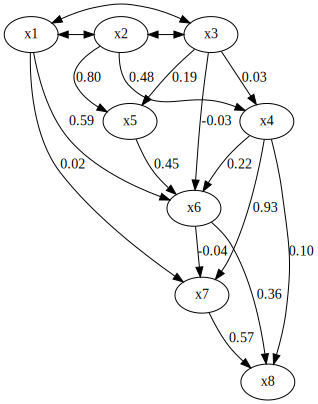

In [45]:
dot = make_dot(adj, labels=X.columns.tolist(), lower_limit=0.00)
dot.render(format="svg")
print(f"model_type: {model_type}")
dot

## Analysis with bootstrapping

To execute the following code, version 1.9.1 or later lingam package is required.  

lingam.tools.bootstrap_with_imputation is a function used to perform causal discovery on datasets that contain missing values.

This section describes how to set `impute_by_mice` to `bootstrap_with_imputation` as the alternative imputer, and how to use MultiGroupRESIT as an alternative causal discovery model.

In [46]:
class CustomizedMultipleImputationWithDV(BaseMultipleImputation):
    """ perform the multiple imputation by mice"""
    
    def __init__(self, n_imputations=10, maxit=10, is_discrete=None, seed=None):
        """
        n_imputations : int, optional (defualt=10)
            The number of multiple imputations.
        maxit : int, optional (default=10)
            The number of iterations.
        is_discrete : array-like of shape (n_features, ), optional (default=None)
            ``is_discrete[i]`` specifies whether the i-th feature is discrete or not.
            All features are considered continuous if ``is_discrete`` is None.
        seed : int, optional (default=None)
            The seed for random numbers.
        """
        self._n_imputations = n_imputations
        self._maxit = maxit
        self._is_discrete = is_discrete
        self._seed = seed
        
    def fit_transform(self, X):
        X_list = impute_by_mice(X, n_imputations=self._n_imputations, maxit=self._maxit, is_discrete=self._is_discrete, seed=self._seed)
        return X_list

In [47]:
class CustomizedMGCDModelWithDV(BaseMultiGroupCDModel):
    """ perform the causal discovery on the multigroup dataset
    """
    
    def __init__(
        self,
        exog_indices,
        endog_indices,
        sink_index,
        is_discrete=None,
        prior_knowledge=None,
        model_type="saenet",
        seed=None
        ):
        """
        exog_indices : list of int
            List of index of exogenous variables.
        endog_indices : list of int
            List of index of endogenous variables.
        sink_index : int
            Index of the sink variable.
        is_discrete : array-like of shape (n_features, ), optional (default=None)
            ``is_discrete[i]`` specifies whether the i-th feature is discrete or not.
            All features are considered continuous if ``is_discrete`` is None.
        prior_knowledge : array-like, shape (n_features, n_features), optional (default=None)
            Prior knowledge used for causal discovery, where ``n_features`` is the number of features.
        model_type : str
            Variable to indicate which model type is used
            Options: "saenet", "logistic", "nonlinear_logistic"
        seed : int, optional (default=None)
            The seed for random numbers.
        """
        self._exog_indices = exog_indices
        self._endog_indices = endog_indices
        self._sink_index = sink_index
        self._is_discrete = is_discrete
        self._model_type = model_type
        self._seed = seed
        
        self._cd_model = MultiGroupCAMUV(
            prior_knowledge=prior_knowledge
        )

    def before_imputation(self, X):
        self._weights = 1 - np.sum(np.isnan(X), axis=1) / X.shape[1]

    def fit(self, X_list):
        # remove effects of exogenous variables from X by regression
        X_removed_exog_list = [remove_effect(X_, self._exog_indices) for X_ in X_list]

        # A list of datasets of endogenous variables with the effects of exogenous variables removed
        X_endog_list = [arr[:, self._endog_indices] for arr in X_removed_exog_list]

        # Causal discovery among endogenous variables after removing the effects of exogenous variables
        self._cd_model.fit(X_endog_list)
        endog_causal_order = adjacency_to_causal_order(cd_model.adjacency_matrix_)

        # Overall causal order
        causal_order = self._exog_indices + [self._endog_indices[i] for i in endog_causal_order] + [self._sink_index]

        if self._model_type == "logistic":
            coefs, intercepts = [], []
            # Indices for predictors (exclude sink in causal discovery)
            exog_and_endog_indices = self._exog_indices + self._endog_indices
            # Linear logistic on raw predictors (exog + endog)
            for X_ in X_list:
                sink_model = LogisticRegression(penalty=None, max_iter=1000)
                sink_model.fit(X_[:, exog_and_endog_indices], X_[:, self._sink_index])
                coefs.append(sink_model.coef_[0])          # shape: (n_features_subset,)
                intercepts.append(sink_model.intercept_[0]) # scalar

            coefs = np.array(coefs)              # (n_imputations, n_features_subset)
            intercepts = np.array(intercepts)    # (n_imputations,)
            median_coef = np.median(coefs, axis=0)
            median_intercept = float(np.median(intercepts))

            adj = np.zeros((X_list[0].shape[1], X_list[0].shape[1]), dtype=float)
            # Create edges following the inferred order (DAG: earlier -> later)
            for i, from_ in enumerate(causal_order):
                for to in causal_order[i+1:]:
                    adj[to, from_] = 1.0
            # Embed endogenous adjacency into the global matri
            adj[np.ix_(self._endog_indices, self._endog_indices)] = self._cd_model.adjacency_matrix_
            # Map median linear coefficients directly into adjacency sink row
            adj[self._sink_index, exog_and_endog_indices] = median_coef

        elif self._model_type == "nonlinear_logistic":
            coefs, intercepts, poly_features_list = [], [], []
            # Indices for predictors (exclude sink in causal discovery)
            exog_and_endog_indices = self._exog_indices + self._endog_indices
            poly_degree = 2
            # Nonlinear logistic with polynomial features (quadratic + interactions)
            for X_ in X_list:
                sink_model = make_pipeline(
                    PolynomialFeatures(degree=poly_degree, include_bias=False),
                    LogisticRegression(max_iter=1000)
                )
                sink_model.fit(X_[:, exog_and_endog_indices], X_[:, self._sink_index])

                coef_vec = sink_model.named_steps['logisticregression'].coef_[0]
                intercept = sink_model.named_steps['logisticregression'].intercept_[0]
                coefs.append(coef_vec)
                intercepts.append(intercept)

                poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
                poly_features.fit(X_[:, exog_and_endog_indices])
                poly_features_list.append(poly_features)

            adj = np.zeros((X_list[0].shape[1], X_list[0].shape[1]), dtype=float)
            # Create edges following the inferred order (DAG: earlier -> later)
            for i, from_ in enumerate(causal_order):
                for to in causal_order[i+1:]:
                    adj[to, from_] = 1.0
            # Embed endogenous adjacency into the global matri
            adj[np.ix_(self._endog_indices, self._endog_indices)] = self._cd_model.adjacency_matrix_
            # Here we set all connections from exogenous and endogenous variables to the sink as 1.0
            # because polynomial coefficients cannot be directly mapped back to original variables.
            adj[self._sink_index, exog_and_endog_indices] = 1.0

        elif self._model_type == "saenet":
            # There is no causal path from exogenous variables to sink variables
            no_paths = [(exog_index_, self._sink_index) for exog_index_ in self._exog_indices]

            prior_knowledge = make_prior_knowledge(
                n_variables=len(causal_order),
                exogenous_variables=self._exog_indices,
                sink_variables=[self._sink_index],
                no_paths=no_paths
            )
            
            adj = estimate_adj_matrix_for_stacked_imputed_datasets(
                X_list,
                causal_order,
                is_discrete=self._is_discrete,
                ad_weight_type="min",
                weights=self._weights,
                prior_knowledge=prior_knowledge,
                seed=self._seed
            )
        else:
            raise ValueError("model_type must be 'logistic', 'nonlinear_logistic', or 'saenet'.")

        # Assume the existence of unobserved common causes among exogenous variables
        for from_ in self._exog_indices:
            for to_ in self._exog_indices:
                if to_ != from_:
                    adj[to_, from_] = np.nan
            
        return causal_order, adj

`bootstrap_with_imputation` is performed to obtain estimation results.

In [48]:
# number of bootstraps
n_sampling = 10

# create instances for multiple imputation and causal discovery
imp_ = CustomizedMultipleImputationWithDV(n_imputations=n_repeats, is_discrete=is_discrete, seed=0)
cd_model_ = CustomizedMGCDModelWithDV(exog_indices, endog_indices, sink_index, model_type=model_type, seed=0)

# send instances
result = bootstrap_with_imputation(X, n_sampling, n_repeats=n_repeats, imp=imp_, cd_model=cd_model_, random_state=0)

causal_orders, adj_list, resampled_indices, imputation_results = result

`n_sampling` causal orders and (`n_sampling` * `n_repeats`) adjacency matrices are estimated.

In [49]:
# (n_sampling, n_features, n_features)
adj_list.shape

(10, 8, 8)

### Confirm results of the bootstrapping

The `adj_list` stores the bootstrap results of `n_sampling` times. To visualize the results of the bootstrap, execute the following code.

* For more information on `lingam.bootstrap.BootstrapResult`, check the `lingam` [manual](https://lingam.readthedocs.io/en/stable/reference/bootstrap.html) and [samples](https://github.com/cdt15/lingam/blob/master/lingam/bootstrap.py).
* For more information on verifying bootstrap results, see [this example notebook](https://github.com/cdt15/lingam/blob/master/examples/Bootstrap.ipynb).

In this example, we assume the data-generating process is non-linear, so we do not estimate (linear) causal effects.
Instead, we use a placeholder for the total effects by setting them to zeros:

In [50]:
dummy_total_effect = np.zeros(adj_list.shape)
bs_result = BootstrapResult(adj_list, dummy_total_effect)

### Causal Directions

In [51]:
# variable names of an estimated adjacency matrix
var_names = X.columns.tolist()

cdc = bs_result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_causal_directions(cdc, n_sampling, labels=var_names)

x6 <--- x4 (b>0) (100.0%)
x7 <--- x4 (b>0) (100.0%)
x6 <--- x5 (b>0) (100.0%)
x6 <--- x1 (b>0) (100.0%)
x5 <--- x3 (b>0) (100.0%)
x8 <--- x7 (b>0) (100.0%)
x4 <--- x2 (b>0) (100.0%)
x5 <--- x2 (b>0) (100.0%)


### Directed Acyclic Graphs

In [52]:
dagc = bs_result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_dagc(dagc, n_sampling, labels=var_names)

DAG[0]: 10.0%
	x4 <--- x2 (b>0)
	x4 <--- x3 (b>0)
	x5 <--- x2 (b>0)
	x5 <--- x3 (b>0)
	x6 <--- x1 (b>0)
	x6 <--- x2 (b<0)
	x6 <--- x3 (b<0)
	x6 <--- x4 (b>0)
	x6 <--- x5 (b>0)
	x7 <--- x4 (b>0)
	x8 <--- x4 (b>0)
	x8 <--- x6 (b>0)
	x8 <--- x7 (b>0)
DAG[1]: 10.0%
	x4 <--- x2 (b>0)
	x4 <--- x3 (b>0)
	x5 <--- x2 (b>0)
	x5 <--- x3 (b>0)
	x6 <--- x1 (b>0)
	x6 <--- x3 (b<0)
	x6 <--- x4 (b>0)
	x6 <--- x5 (b>0)
	x7 <--- x2 (b<0)
	x7 <--- x3 (b>0)
	x7 <--- x4 (b>0)
	x7 <--- x5 (b<0)
	x7 <--- x6 (b<0)
	x8 <--- x4 (b>0)
	x8 <--- x6 (b>0)
	x8 <--- x7 (b>0)
DAG[2]: 10.0%
	x4 <--- x2 (b>0)
	x4 <--- x3 (b>0)
	x5 <--- x2 (b>0)
	x5 <--- x3 (b>0)
	x6 <--- x1 (b>0)
	x6 <--- x3 (b<0)
	x6 <--- x4 (b>0)
	x6 <--- x5 (b>0)
	x7 <--- x1 (b>0)
	x7 <--- x4 (b>0)
	x7 <--- x5 (b<0)
	x8 <--- x4 (b>0)
	x8 <--- x5 (b>0)
	x8 <--- x6 (b>0)
	x8 <--- x7 (b>0)


### Bootstrap probability

In [53]:
prob = bs_result.get_probabilities(min_causal_effect=None)
pd.DataFrame(prob, index=X.columns, columns=X.columns)

,x1,x2,x3,x4,x5,x6,x7,x8
x1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x4,0.8,1.0,1.0,0.0,0.0,0.0,0.0,0.0
x5,0.6,1.0,1.0,0.3,0.0,0.0,0.0,0.0
x6,1.0,0.5,0.7,1.0,1.0,0.0,0.0,0.0
x7,0.4,0.4,0.3,1.0,0.3,0.7,0.0,0.0
x8,0.0,0.0,0.0,1.0,0.3,0.9,1.0,0.0


### Bootstrap Probability of Path

In [54]:
from_var_name = "x4"
to_var_name = "x8"
display(Markdown(f"#### {from_var_name}→{to_var_name}"))

path = bs_result.get_paths(var_names.index(from_var_name), var_names.index(to_var_name))
path = pd.DataFrame(path)

path["path"] = path["path"].apply(lambda indices: [var_names[i] for i in indices])

path[["path", "probability"]]

#### x4→x8

,path,probability
0,"[x4, x7, x8]",1.0
1,"[x4, x8]",1.0
2,"[x4, x6, x8]",0.9
3,"[x4, x6, x7, x8]",0.7
4,"[x4, x5, x6, x7, x8]",0.3
5,"[x4, x5, x6, x8]",0.3
6,"[x4, x5, x8]",0.2
7,"[x4, x5, x7, x8]",0.1
